# Aprendizaje automático y aplicaciones

## Clasificación de imágenes con redes neuronales (caso de estudio)

---
$A^3$ @ FI-UNER : 2021

In [1]:
# Imports básicos
from matplotlib import pyplot as plt
import numpy as np
import torch as tr
import pandas as pd 
import seaborn as sns 

## Definición de los dataloaders

In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder


batch_size = 32
img_size = 250

train_transforms = transforms.Compose([transforms.Grayscale(),
                                       transforms.Resize((img_size, img_size)),
                                       # Rotaciones y escalados aleatorios
                                       transforms.RandomAffine(degrees=20, 
                                                               scale=(0.5, 1.2), 
                                                               translate=(.2, .2), 
                                                               fill=255),  
                                       transforms.ToTensor()]) 

train_data = ImageFolder("train_dataset/", transform=train_transforms)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Para validación/test, usamos solo las transformaciones necesarias para llevar 
los datos a la misma escala 
test_transforms = transforms.Compose([transforms.Grayscale(),
                                      transforms.Resize((img_size, img_size)),
                                      transforms.ToTensor()]) 

valid_data = ImageFolder("valid_dataset/", transform=test_transforms)
valid_loader = DataLoader(valid_data, batch_size=batch_size)



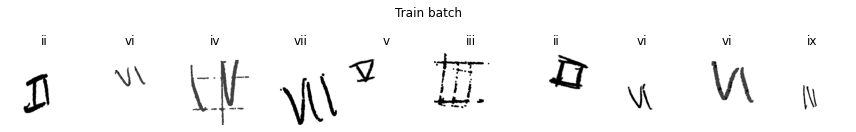

In [3]:
fig, ax = plt.subplots(1, 10, figsize=(12, 2))
ax = ax.ravel()
for batch_im, batch_label in train_loader:
    # grafico solo las primeras 10 imágenes del batch
    for k in range(10):
        # el tensor es de tamaño (C, H, W) 
        ax[k].imshow(batch_im[k, :, :, :].squeeze(), cmap="gray")  
        ax[k].set_title(train_data.classes[batch_label[k]])
        ax[k].axis("off")
    break
plt.suptitle("Train batch")    
plt.tight_layout()

In [4]:
batch_im.shape

torch.Size([32, 1, 250, 250])

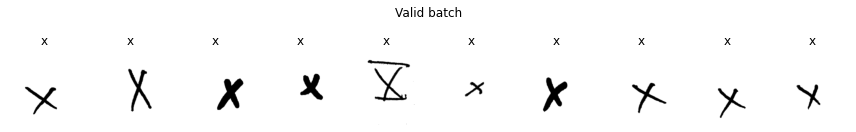

In [5]:
fig, ax = plt.subplots(1, 10, figsize=(12, 2))
ax = ax.ravel()
for batch_im, batch_label in valid_loader:
    # grafico solo las primeras 10 imágenes del batch
    for k in range(10):
        # el tensor es de tamaño (C, H, W) 
        ax[k].imshow(batch_im[k, :, :, :].squeeze(), cmap="gray")  
        ax[k].set_title(train_data.classes[batch_label[k]])
        ax[k].axis("off")
plt.suptitle("Valid batch")    
plt.tight_layout()

## Definición de la arquitectura

Para este problema vamos a usar una red convolucional de 2 dimensiones. La siguiente clase contine la red en si misma, el optimizador, la función de costo y las funciones auxiliares para entrenar y evaluar el modelo


In [6]:
from torch import nn, optim
from sklearn.metrics import balanced_accuracy_score

class CNN(nn.Module):
    '''
    Red neuronal convolucional 2D.    
    '''
    
    def __init__(self, input_size, i_channels, n_outputs, device):
        
        super(CNN, self).__init__()
        
        self.cnn = nn.Sequential(nn.Conv2d(i_channels, 32, kernel_size=3),
                                 nn.MaxPool2d(4),
                                 nn.ReLU(),
                                 nn.Conv2d(32, 64, kernel_size=3),
                                 nn.MaxPool2d(4),
                                 nn.ReLU(),
                                 nn.Conv2d(64, 128, kernel_size=3),
                                 nn.MaxPool2d(4),
                                 nn.ReLU()
                                )
            
        self.fc = nn.Linear(1152, n_outputs)
        
        self.loss_criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=1e-3)
        
        self.to(device)
        self.device = device

    def forward(self, x):
        
        y = self.cnn(x) # etapa convolucional
        y = self.fc(y.view(x.shape[0], -1)) # flatten y fully-connected

        return y  
    
    def train_step(self, dataloader):
        self.train()  
        cummulated_loss = 0
    
        for X, y in dataloader:

            self.optimizer.zero_grad()  
            y_pred = self(X.to(self.device))
            
            loss = self.loss_criterion(y_pred, y.to(self.device))
        
            cummulated_loss += loss.item() / len(dataloader)
        
            loss.backward()
            self.optimizer.step()
        
        return cummulated_loss
    
    
    def valid_step(self, dataloader):
        self.eval()  
        cummulated_loss = 0
        
        y_all, y_pred_all = [], []
        
        for X, y in dataloader:
          
            y_pred = self(X.to(self.device))
            
            # Acumulamos predicciones y etiquetas para calcular accuracy al final
            y_pred_all.append(tr.argmax(y_pred, axis=1).cpu().detach())
            y_all.append(y.cpu())
            
            loss = self.loss_criterion(y_pred, y.to(self.device))
        
            cummulated_loss += loss.item() / len(dataloader)
            
        
        bal_acc = balanced_accuracy_score(tr.cat(y_all), tr.cat(y_pred_all))
        return cummulated_loss, bal_acc


net = CNN(img_size, 1, 10, device="cuda")
net

CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
  )
  (fc): Linear(in_features=1152, out_features=10, bias=True)
  (loss_criterion): CrossEntropyLoss()
)

## Entrenamiento

In [7]:
MAX_EPOCHS = 200
best_loss = 9999
model = CNN(img_size, 1, 10, device="cuda")

epoch = 0
counter = 0

log = {"train_loss": [], "valid_loss": [], "valid_bal_acc": []}

while (epoch < MAX_EPOCHS) and (counter < 20):
    
    #------------
    # TRAIN
    #------------
    train_loss = model.train_step(train_loader)
    valid_loss, valid_bal_acc = model.valid_step(valid_loader)
    
    log["train_loss"].append(train_loss)
    log["valid_loss"].append(valid_loss)
    log["valid_bal_acc"].append(valid_bal_acc)
    
    #=================================
    if (valid_loss < best_loss):
        
        # Actualizo best_loss
        best_loss = valid_loss
        best_epoch = epoch
        
        # Guardo mejor modelo
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
    #=================================

    if epoch % 10 == 0:
        print(f"Epoch {epoch: 03d}: train loss {train_loss: .2f} | valid loss {valid_loss: .2f} | valid balanced accuracy {valid_bal_acc: .2f}")
    epoch += 1

tr.save(best_model, 'cnn2d_augm.pmt')

/home/leandro/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch  00: train loss  2.30 | valid loss  2.34 | valid balanced accuracy  0.10
Epoch  10: train loss  1.33 | valid loss  1.08 | valid balanced accuracy  0.65
Epoch  20: train loss  1.05 | valid loss  0.77 | valid balanced accuracy  0.75
Epoch  30: train loss  0.92 | valid loss  0.71 | valid balanced accuracy  0.76
Epoch  40: train loss  0.84 | valid loss  0.70 | valid balanced accuracy  0.75
Epoch  50: train loss  0.77 | valid loss  0.60 | valid balanced accuracy  0.79
Epoch  60: train loss  0.74 | valid loss  0.62 | valid balanced accuracy  0.79
Epoch  70: train loss  0.71 | valid loss  0.57 | valid balanced accuracy  0.79
Epoch  80: train loss  0.67 | valid loss  0.52 | valid balanced accuracy  0.80
Epoch  90: train loss  0.65 | valid loss  0.64 | valid balanced accuracy  0.77
Epoch  100: train loss  0.64 | valid loss  0.57 | valid balanced accuracy  0.80
Epoch  110: train loss  0.57 | valid loss  0.55 | valid balanced accuracy  0.80


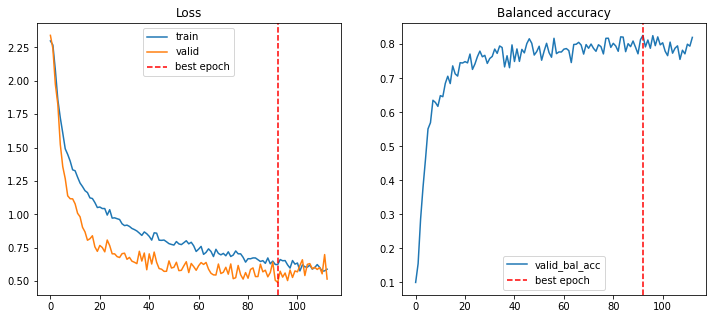

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(log["train_loss"], label="train")
plt.plot(log["valid_loss"], label="valid")
#plt.plot(best_epoch, [min(log["train_loss"]), max(log["train_loss"])])
plt.axvline(best_epoch, color="r", linestyle="--", label="best epoch")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(log["valid_bal_acc"], label="valid_bal_acc")
plt.axvline(best_epoch, color="r", linestyle="--", label="best epoch")
plt.legend()
plt.title("Balanced accuracy");


## Análisis de resultados

Vemos que la evaluación en train/validación parece razonable, ahora evaluamos en la partición de test

In [7]:
test_data = ImageFolder("test_dataset/", transform=test_transforms)
test_loader = DataLoader(valid_data, batch_size=batch_size)

# Cargamos el mejor modelo
model = CNN(img_size, 1, 10, device="cpu")
model.load_state_dict(tr.load("cnn2d.pmt"))

test_loss, test_bal_acc = model.valid_step(test_loader)
print(f"Test loss {test_loss: .3f}, Test balanced accuracy {test_bal_acc: .3f}")

/home/leandro/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test loss  0.699, Test balanced accuracy  0.750


En clasificación, la matriz de confusión nos da una mejor idea de que esta pasando

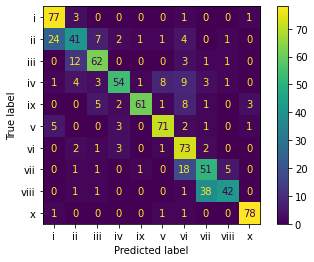

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

model.eval()
pred, labels = [], []
for img, label in test_loader:
    out = model(img).detach().cpu()
    
    labels.append(label)
    pred.append(tr.argmax(out, axis=1))
    
labels = tr.cat(labels)
pred = tr.cat(pred)
confm = confusion_matrix(labels, pred)

ConfusionMatrixDisplay(confm, display_labels=train_data.classes).plot();

## Análisis de las activaciones respecto a la aumentación de datos




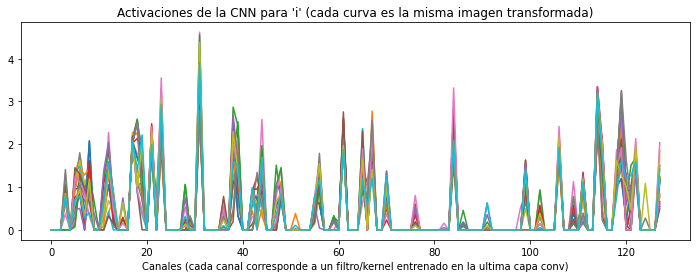

In [10]:
from PIL import Image 

original_img = Image.open(train_data.samples[0][0])

img_transform = transforms.Compose([transforms.Grayscale(),
                                    transforms.Resize((img_size, img_size)),
                                    transforms.RandomAffine(degrees=0, 
                                                            translate=(.2, .2), 
                                                            fill=255),  
                                    transforms.ToTensor()]) 


max_activation = tr.zeros((20, 128))
max_pool = nn.AdaptiveMaxPool2d(1)

for k in range(20):
    im = img_transform(original_img)
    
    # Salida de la etapa convolucional
    # notar que solo hago el forward de la CNN, sin la FC
    out = model.cnn(im.unsqueeze(0)).detach() 
    
    max_activation[k, :] = max_pool(out).squeeze()
    
plt.figure(figsize=(12, 4))
plt.plot(max_activation.T);
plt.xlabel("Canales (cada canal corresponde a un filtro/kernel entrenado en la ultima capa conv)")
plt.title("Activaciones de la CNN para 'i' (cada curva es la misma imagen transformada)");


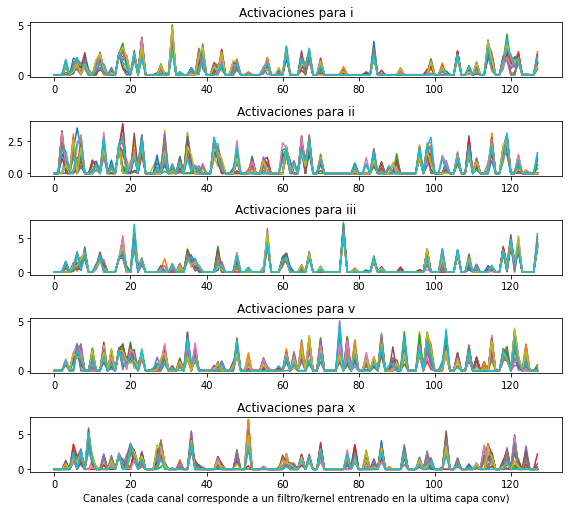

In [11]:
fig, ax = plt.subplots(5, 1, figsize=(8, 7))

for i, ind in enumerate([0, 300, 500, 1200, 1900]):
    original_img = Image.open(train_data.samples[ind][0])
    label = train_data.classes[train_data.samples[ind][1]]

    max_activation = tr.zeros((20, 128))

    # Genero transformaciones aleatorias de la misma imagen
    for k in range(20):
        im = img_transform(original_img)
       
        # Salida de la etapa convolucional
        out = model.cnn(im.unsqueeze(0)).detach() # notar que solo hago el forward de la CNN, sin la FC
    
        max_activation[k, :] = max_pool(out).squeeze()
    
    ax[i].plot(max_activation.T)
    ax[i].set_title(f"Activaciones para {label}")
    plt.tight_layout()
plt.xlabel("Canales (cada canal corresponde a un filtro/kernel entrenado en la ultima capa conv)");


## Análisis de función de pérdida sobre los datos
Si bien el principal objetivo de la función de pérdida es guiar la optimización del modelo, es una métrica que suele ser muy útil para estudiar los datos en sí mismos. 

En este ejemplo, si bien los datos son relativamente simples, puede ser complejo determinar problemas con los datos. Por ejemplo, datos mal etiquetados, imagenes que no son dígitos, etc.

Con el modelo entrenado podemos hacer un analisis como este

In [12]:
# Recorremos el dataset de entrenamiento y guardamos el loss para cada ejemplo
imgs, labels, losses = [], [], []

# devuelve el loss para cada ejemplo en vez de promediar el batch
criterion = nn.CrossEntropyLoss(reduction="none") 

for im, label in train_loader:
    out = model(im).detach()
    
    imgs.append(im) # lo ideal sería guardar nombres de archivo, no imagenes!
    labels.append(label)    
    losses.append(criterion(out, label))    
    
losses = tr.cat(losses)
labels = tr.cat(labels)
imgs = tr.cat(imgs)

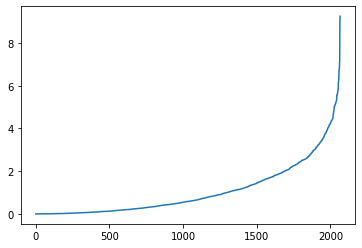

In [13]:
ind = tr.argsort(losses)

plt.plot(losses[ind])


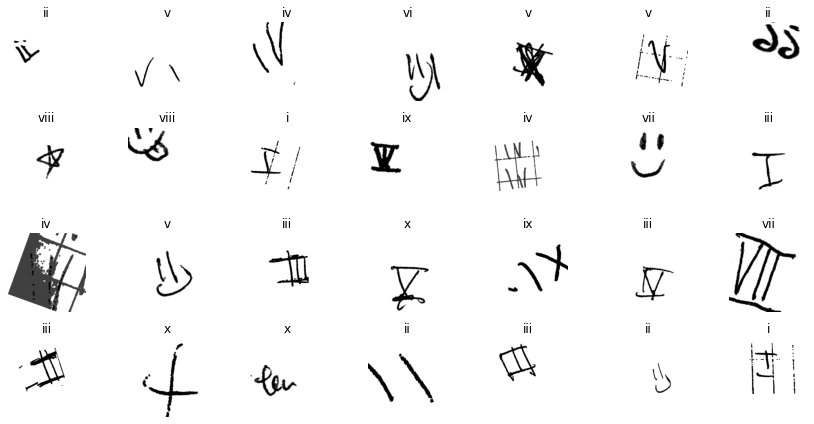

In [14]:
ind_raros = np.where(losses > 5)[0]

fig, ax = plt.subplots(4, 7, figsize=(12, 6))
ax = ax.ravel()
for k, ind in enumerate(ind_raros):
    if k >= 28:
        break 
    ax[k].imshow(imgs[ind, :, :, :].squeeze(), cmap="gray")
    ax[k].set_title(train_data.classes[labels[ind]])
    ax[k].axis("off")
    
    
plt.tight_layout()